# Laboratory 04: Q-Learning  
Student:АКТЕР АИРИН  
Group: 5140201/30301  
Master Degree in Artificial Intelligence and Machine Learning  

### Q-Learning Agent

In [5]:
# import packages
import sys, os 
import numpy as np 
import matplotlib.pyplot as plt 
from collections import defaultdict
import random
import math 

In [6]:
#               --- Q-Learning agent ---

class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_legal_actions):
        """        
        Variables:
        - alpha: learning rate
        - epsilon: exploration probability
        - gamma: discount rate
        """
        self.get_legal_actions = get_legal_actions
        self.qvalues = defaultdict(lambda: defaultdict(lambda:0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

    def get_qvalue(self, state, action):
        return self.qvalues[state][action]
        
    def set_qvalue(self, state, action, value):
        self.qvalues[state][action] = value
    
    # in each state, get the best Q-value
    # V(s_t+1) = max{Q(s_t+1, a_t+1)} ==> maximum value in Q-table
    def get_value(self, state):
        # take possible actions from currently state
        set_actions = self.get_legal_actions(state)
        # check if don't have actions
        if len(set_actions) == 0:
            return 0.0        
        # calculate V(s_t+1)
        value = max(self.get_qvalue(state, action) for action in set_actions)

        return value

    # update the value
    # Q(s_t, a_t) = (1 - alpha) * Q(s_t, a_t) + alpha * (r(s_t, a_t) + gamma * max{Q(s_t+1, a_t+1)})
    def update_value(self, state, action, reward, next_state):
        # calculate Q(s_t, a_t)
        q_value = (1 - self.alpha) * self.get_qvalue(state, action) + \
                    self.alpha * (reward + self.gamma * self.get_value(next_state))
        # update the Q-table with the new value
        self.set_qvalue(state, action, q_value)

    # choose the best action
    def get_best_action(self, state):
        # take possible actions for currently state
        set_actions = self.get_legal_actions(state)
        # check if don't have actions
        if len(set_actions) == 0:
            return None
        # initialize best action
        best_action = None
        # initialize q-value
        best_qvalue = float('-inf')

        # check q-value for each action, and take the best action
        for action in set_actions:
            q_value = self.get_qvalue(state, action)

            if q_value > best_qvalue:
                best_action = action 
                best_qvalue = q_value

        return best_action
    
    # epsilon-greedy algorithm to choose action randomly or best
    def get_action(self, state):
        # take all possible actions for currently state
        set_actions = self.get_legal_actions(state)
        # check if don't have action
        if len(set_actions) == 0:
            return None 
        # compete randomly or best action
        if random.uniform(0, 1) < self.epsilon:
            chosen_action = random.choice(set_actions)
        else:
            chosen_action = self.get_best_action(state)

        return chosen_action

### Taxi environment

Environment and Q-Agent

In [19]:
# import package
import gym

# define environment
env = gym.make("Taxi-v3")

# number of actions
n_actions = env.action_space.n
print("#actions = ", n_actions)

# define agent
agent = QLearningAgent(alpha = 0.5, epsilon = 0.25, gamma = 0.99,
                       get_legal_actions = lambda s:range(n_actions))


#actions =  6


Q-Learning Algorithm  
  
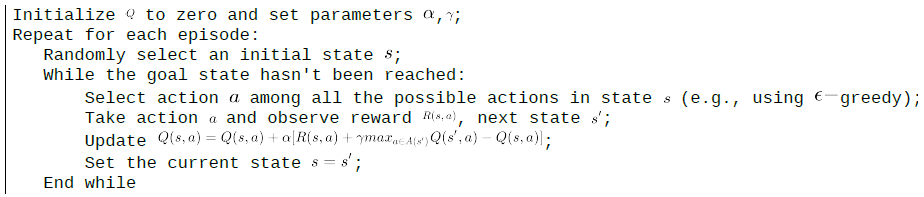

In the Q-Learning Algorithm, we take in account the exploration and exploitation in environment system.  
- Exploration:  
try something new, getting more information about the environment ==> use random choice criteria to select action  
- Exploitation:  
make the best decision based on all the information that you have ==> use max criteria to select action  
  
Thus, epsilon-greedy balance the exploration (random decision making) and exploitation (best decision making) 

In [20]:
# agent play using policy of epsilon-greedy agent
def play_and_train(env, agent, t_max = 10**4):
    # define total reward
    total_reward = 0.0
    # reset environment and take initial state
    s, _ = env.reset()
    # train many interations
    for t in range(t_max):
        # agent pick action given state s
        a = agent.get_action(s)
        # next step
        next_state, r, done, _, _ = env.step(a)
        # update value
        agent.update_value(s, a, r, next_state)
        # update state
        s = next_state
        # update reward 
        total_reward += r

        if done:
            break

    return total_reward


Visualization of results

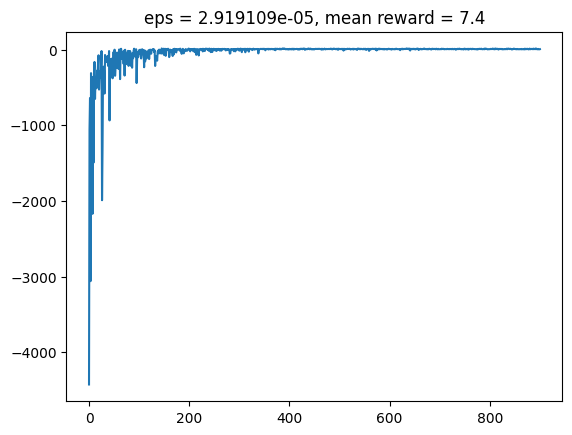

In [21]:
# import package
from IPython.display import clear_output 

rewards = [] 

# generate 1000 iterations
for i in range(1000): 
    rewards.append(play_and_train(env, agent)) 
    agent.epsilon *= 0.99 
    if i % 100 == 0: 
        clear_output(True) 
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:]))) 
        plt.plot(rewards) 
        plt.show()

### Discretized state spaces: Cart-Pole  
The Cart-Pole is made up of a cart that can move horizontally and a pole can move rotationally,  
with respect the center of the cart. The pole is pivoted by the cart.

Hints:  
- Use agent to train efficiently on CartPole-v0. 
- This environment has a continuous set of possible states, so you will have to group them into bins somehow.
- The simplest way is to use round(x, n_digits) (or np.round) to round a real number to a given amount of digits. 
- The tricky part is to get the n_digits right for each state to train effectively.
- Note that you don't need to convert state to integers, but to tuples of any kind of values.

first state: [ 0.03639362  0.00480906 -0.03401204  0.02625522]


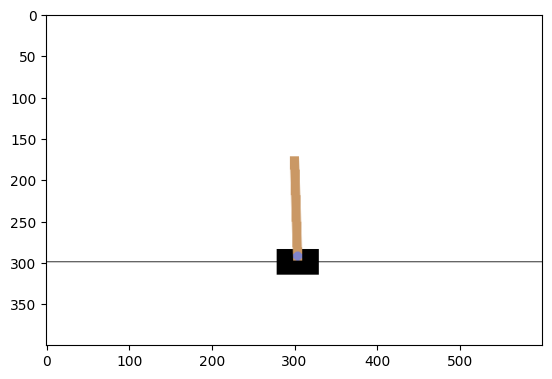

In [23]:
# take environment with RGB-pixel values
def make_env():
    return gym.make('CartPole-v0', render_mode='rgb_array').env

env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()[0]))
plt.imshow(env.render())

Play a few games and observate distribution

In [24]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)    
    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    for i, title in enumerate(['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']):
        ax = axarr[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    f.tight_layout()

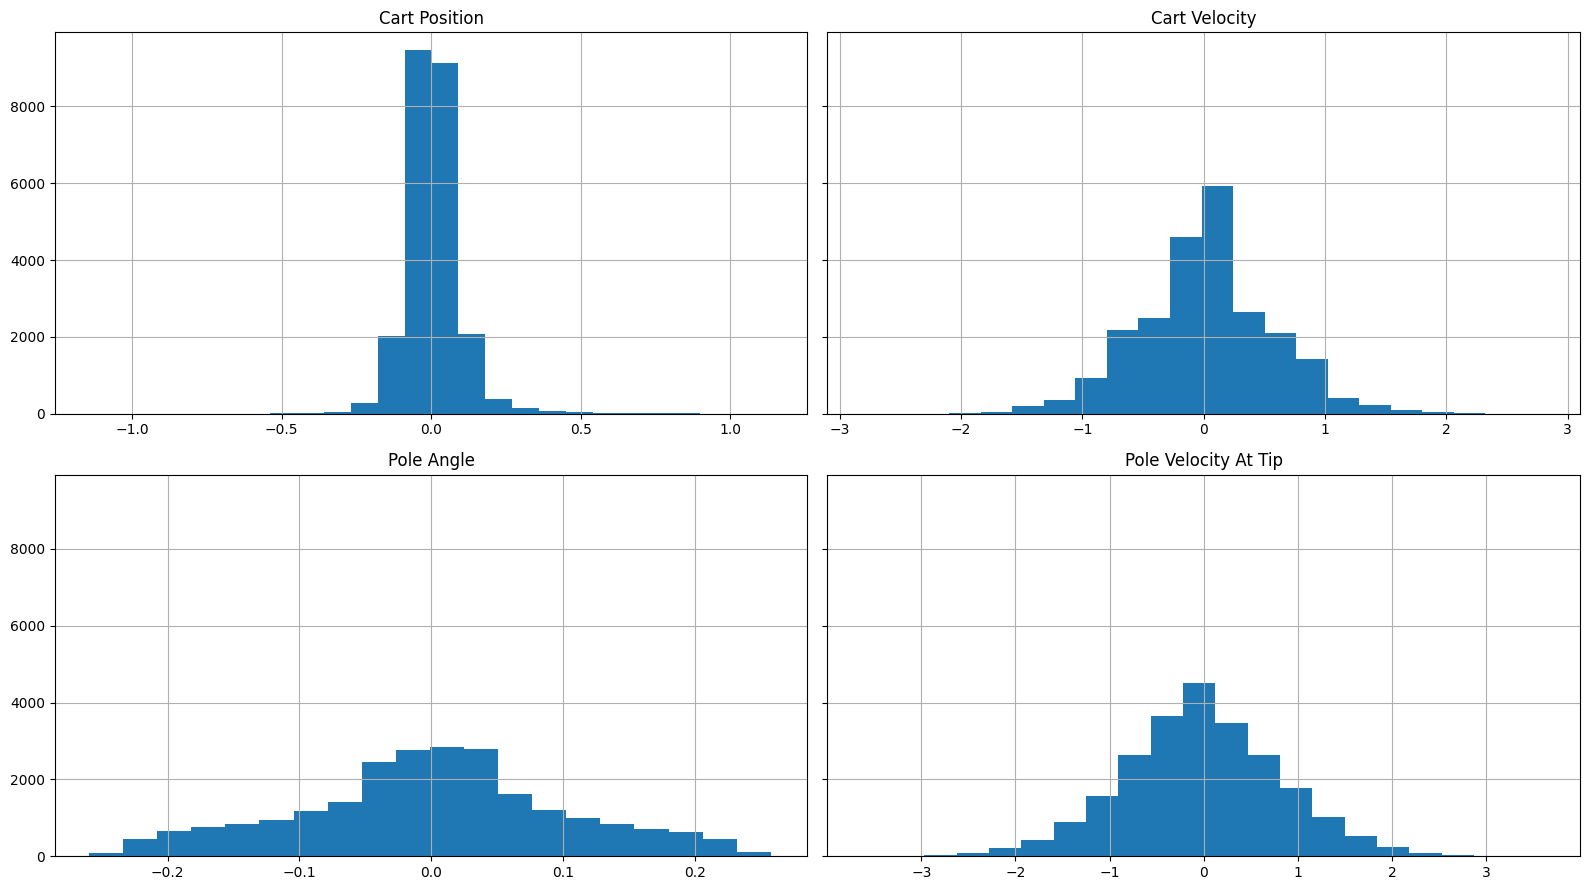

In [26]:
# vector with all observations
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# list of observations
seen_observations = []

# play 1000 iterations
for _ in range(1000):
    s, _ = env.reset()
    seen_observations.append(s)
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        
visualize_cartpole_observation_distribution(seen_observations)

In [27]:
from gym.core import ObservationWrapper

# function to discretize the RGB-pixels
class Discretizer(ObservationWrapper):
    def observation(self, state):
        # Hint: you can do that with round(x, n_digits).
        # You may pick a different n_digits for each dimension.
        state = tuple(round(x, n_digits) for x, n_digits in zip(state, [2, 2, 4, 3]))

        return state

g:\_MASTER DEGREE - AI POLYTECH\ИКНТ - 3 курс\1 - Глубокое Обучение\ReinforcementLearning-Labs\rl_env\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


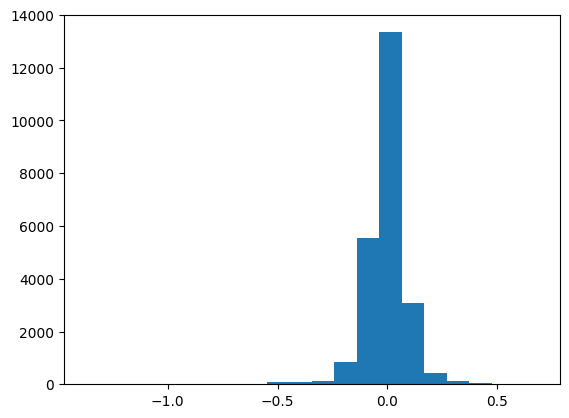

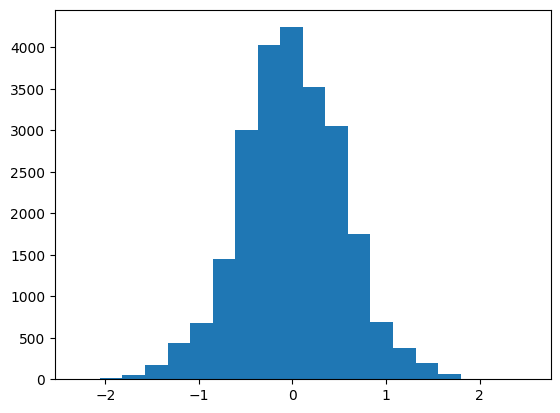

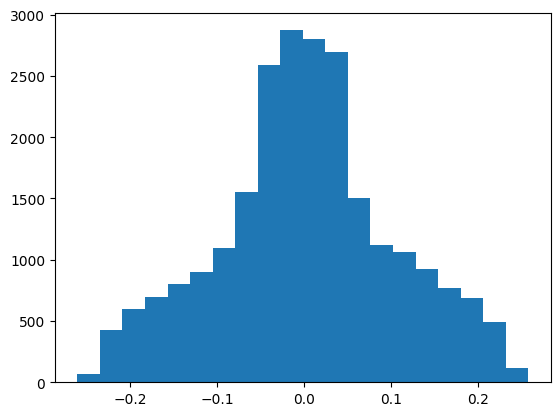

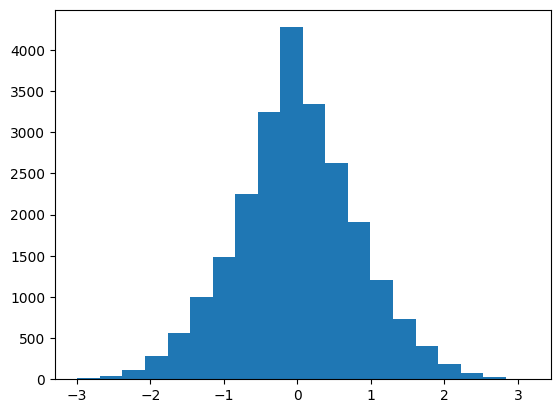

In [28]:
# generate cart-pole discretized environment
env2 = Discretizer(gym.make("CartPole-v0")).env

# make experiment
seen_observations = []
for _ in range(1000):
    s, _ = env.reset()
    seen_observations.append(s)
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        if done:
            break

# convert it in numpy array
seen_observations = np.array(seen_observations) 

# check results
for obs_i in range(env.observation_space.shape[0]): 
    plt.hist(seen_observations[:, obs_i], bins=20) 
    plt.show()